<a href="https://colab.research.google.com/github/ViniPMartins/desafio-alura-ml/blob/main/Fraude_em_transa%C3%A7%C3%B5es_de_cart%C3%A3o_de_cr%C3%A9dito.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
from google.colab import userdata
import json

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import sklearn
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, precision_score
from sklearn.model_selection import GridSearchCV

from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

from sklearn.feature_selection import RFE

import numpy as np
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE

# Baixando os dados do Kaggle

Este notebook foi desenvolvido usando o google Colab. Por isso, para que funcione, é necessário inserir as variáveis de ambiente "username" e "key" para a leitura dos dados através da API do kaggle. Caso esteja usando outro ambiente, é necessário adaptar o key_authentication

Essas informações podem ser obtidas indo na página de configurações do kaggle, no botão "Create Newttoken".

In [ ]:
key_authentication = {
    "username" : userdata.get('username'),
    "key" : userdata.get('key')
}

key_authentication = json.dumps(key_authentication)

In [ ]:
with open("/content/kaggle.json", "w") as arquivo:
    arquivo.write(key_authentication)

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle

kaggle.json


In [ ]:
!kaggle competitions download -c fraude-em-transaes-de-carto-de-crdito

fraude-em-transaes-de-carto-de-crdito.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
#!mkdir datasets
!unzip -o /content/fraude-em-transaes-de-carto-de-crdito.zip -d datasets

Archive:  /content/fraude-em-transaes-de-carto-de-crdito.zip
  inflating: datasets/exemplo_submissao.csv  
  inflating: datasets/teste.csv.xz   
  inflating: datasets/treino.csv.xz  


In [ ]:
!kaggle competitions submit --help

usage: kaggle competitions submit [-h] -f FILE_NAME -m MESSAGE [-q] [competition]

required arguments:
  -f FILE_NAME, --file FILE_NAME
                        File for upload (full path)
  -m MESSAGE, --message MESSAGE
                        Message describing this submission

options:
  -h, --help            show this help message and exit
  competition           Competition URL suffix (use "kaggle competitions list" to show options)
                        If empty, the default competition will be used (use "kaggle config set competition")"
  -q, --quiet           Suppress printing information about the upload/download progress


# Lendo os dados

In [ ]:
path_treino = "datasets/treino.csv.xz"
df_treino = pd.read_csv(path_treino, sep='|')

path_teste = "datasets/teste.csv.xz"
df_teste = pd.read_csv(path_teste, sep='|')

path_exemplo_submissao = "datasets/exemplo_submissao.csv"
df_exemplo_submissao = pd.read_csv(path_exemplo_submissao)

In [ ]:
print("Tamanho dados de treino: {}".format(df_treino.shape))
print("Tamanho dados de teste: {}".format(df_teste.shape))
print("Tamanho dados de exemplo de submissao: {}".format(df_exemplo_submissao.shape))
print("Proporção dados de teste em relação aos de treino: {:2%}".format(df_teste.shape[0]/df_treino.shape[0]))

Tamanho dados de treino: (144352, 26)
Tamanho dados de teste: (36047, 25)
Tamanho dados de exemplo de submissao: (1742528, 2)
Proporção dados de teste em relação aos de treino: 24.971597%


In [ ]:
df_treino.columns

Index(['ssn', 'cc_num', 'first', 'last', 'gender', 'street', 'city', 'state',
       'zip', 'lat', 'long', 'city_pop', 'job', 'dob', 'acct_num', 'profile',
       'trans_num', 'trans_date', 'trans_time', 'unix_time', 'category', 'amt',
       'is_fraud', 'merchant', 'merch_lat', 'merch_long'],
      dtype='object')

In [ ]:
df_teste.columns

Index(['ssn', 'cc_num', 'first', 'last', 'gender', 'street', 'city', 'state',
       'zip', 'lat', 'long', 'city_pop', 'job', 'dob', 'acct_num', 'profile',
       'trans_num', 'trans_date', 'trans_time', 'unix_time', 'category', 'amt',
       'merchant', 'merch_lat', 'merch_long'],
      dtype='object')

In [ ]:
df_exemplo_submissao.columns

Index(['trans_num', 'is_fraud'], dtype='object')

In [ ]:
df_teste['trans_num'].values

array(['a4194096c6cc870b2e21b2b2f69a7706',
       'f12645668a1a5a9f8192687f56095b5a',
       '7f8e03dcf31fbbb5a3547ed8c40fa54b', ...,
       '3ddceea33fc57d78ea462439271f8392',
       '582e6c05bf038dedb8a301c092b3d09f',
       '1c0907340f9311ecdb1bd1e64822ab92'], dtype=object)

In [ ]:
ser = df_exemplo_submissao['trans_num'].isin(df_teste['trans_num'].head().values)
ser.groupby(ser).count()

trans_num
False    1742528
Name: trans_num, dtype: int64

# Visualização e Limpeza inicial dos dados

> Tarefas

1. Remover dados nulos e remover colunas não necessárias
2. Extrair dia, mês e ano
3. Verificar balanceamento dos dados
4. Montar Pipeline de transformação dos dados


> Dicionário de dados:

* index - Identificador único para cada linha
* trans_date_trans_time - Data e hora da transação
* cc_num - Número do cartão de crédito do cliente
* merchant - Nome do comerciante
* category - Categoria do comerciante
* amt - Valor da transação
* first - Primeiro nome do titular do cartão de crédito
* last - Sobrenome do titular do cartão de crédito
* gender - Gênero do titular do cartão de crédito
* street - Endereço residencial do titular do cartão de crédito
* city - Cidade do titular do cartão de crédito
* state - Estado do titular do cartão de crédito
* zip - CEP do titular do cartão de crédito
* lat - Localização de latitude do titular do cartão de crédito
* long - Localização de longitude do titular do cartão de crédito
* city_pop - População da cidade do titular do cartão de crédito
* job - Profissão do titular do cartão de crédito
* dob - Data de nascimento do titular do cartão de crédito
* trans_num - Número da transação
* unix_time - Horário UNIX da transação
* merch_lat - Localização de latitude do comerciante
* merch_long - Localização de longitude do comerciante
* is_fraud - Indicador de fraude <--- Classe Alvo



## Limpando colunas, dados nulos e tipos das colunas

In [ ]:
df_treino.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144352 entries, 0 to 144351
Data columns (total 26 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   ssn         144352 non-null  object 
 1   cc_num      144352 non-null  int64  
 2   first       144352 non-null  object 
 3   last        144352 non-null  object 
 4   gender      144352 non-null  object 
 5   street      144352 non-null  object 
 6   city        144352 non-null  object 
 7   state       144352 non-null  object 
 8   zip         1468 non-null    float64
 9   lat         144352 non-null  float64
 10  long        144352 non-null  float64
 11  city_pop    144352 non-null  int64  
 12  job         144352 non-null  object 
 13  dob         144352 non-null  object 
 14  acct_num    144352 non-null  int64  
 15  profile     144352 non-null  object 
 16  trans_num   144194 non-null  object 
 17  trans_date  144194 non-null  object 
 18  trans_time  144194 non-null  object 
 19  un

In [ ]:
pd.set_option('display.max_columns', None)
df_treino.head()

,ssn,cc_num,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,acct_num,profile,trans_num,trans_date,trans_time,unix_time,category,amt,is_fraud,merchant,merch_lat,merch_long
0,176-11-8190,6591803397401489,Justin,Johnson,M,39261 Martin Garden Suite 856,Murrieta,CA,NaN,33.57,-117.18,115971,Counselling psychologist,1976-11-30,797529515996,adults_2550_male_urban.json,556df8e74106df46d235d77659fb435f,2023-07-23,15:23:53,1.690137e+09,misc_pos,2.27,0.0,fraud_Thiel PLC,NaN,NaN
1,481-92-6127,4772233060463333,Andrea,Ho,F,757 Ronald Trail Apt. 965,Ontario,CA,NaN,34.08,-117.63,166856,"Nurse, mental health",1962-07-29,630254100367,adults_50up_female_urban.json,c7567a1fbf9774505a8682283fc1c887,2023-12-13,22:13:50,1.702516e+09,home,10.52,0.0,"fraud_Koss, Hansen and Lueilwitz",NaN,NaN
2,849-66-8722,30470551694093,John,Coffey,M,097 Alexandria Stravenue,Lancaster,CA,NaN,34.69,-118.15,182305,Water quality scientist,1983-04-05,926744876615,adults_2550_male_urban.json,7ac47082c43d97b1adfc78a8de84579b,2023-07-23,23:46:47,1.690167e+09,misc_pos,149.01,0.0,fraud_Haley Group,NaN,NaN
3,392-97-2182,4189092753269739,Angelica,Garcia,F,656 Moody Gateway,Carson City,NV,NaN,39.17,-119.78,61818,Health and safety inspector,1968-08-31,92962937500,adults_50up_female_urban.json,dcff610c572fcd800b8df0b5989e552e,2024-01-29,16:45:57,1.706558e+09,personal_care,32.01,0.0,"fraud_Lubowitz, Terry and Stracke",NaN,NaN
4,742-37-0405,180088770435813,Travis,Jackson,M,133 Houston Ford,Rochester,NY,NaN,43.17,-77.56,478127,Soil scientist,1958-05-19,772358594412,adults_50up_male_urban.json,3c6124136bfe76c8bd52bec6c398e868,2023-06-18,04:16:14,1.687073e+09,misc_pos,137.31,0.0,fraud_McGlynn-Jaskolski,NaN,NaN


In [ ]:
df_treino_prep = df_treino.dropna(subset='is_fraud', axis=0).copy()
df_treino_prep.drop(['zip', 'merch_lat', 'merch_long', 'first', 'last', 'gender', 'street', 'lat', 'long', 'ssn', 'trans_num'], axis=1, inplace=True)

df_treino_prep['trans_date'] = pd.to_datetime(df_treino_prep['trans_date'])
df_treino_prep['trans_time'] = pd.to_datetime(df_treino_prep['trans_time'])
df_treino_prep['dia'] = df_treino_prep['trans_date'].dt.day
df_treino_prep['mes'] = df_treino_prep['trans_date'].dt.month
df_treino_prep['ano'] = df_treino_prep['trans_date'].dt.year
df_treino_prep['hora'] = df_treino_prep['trans_time'].dt.hour
df_treino_prep['minuto'] = df_treino_prep['trans_time'].dt.minute

<ipython-input-16-a5c8774c4daa>:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_treino_prep['trans_time'] = pd.to_datetime(df_treino_prep['trans_time'])


In [ ]:
df_treino_prep.head()

,cc_num,city,state,city_pop,job,dob,acct_num,profile,trans_date,trans_time,unix_time,category,amt,is_fraud,merchant,dia,mes,ano,hora,minuto
0,6591803397401489,Murrieta,CA,115971,Counselling psychologist,1976-11-30,797529515996,adults_2550_male_urban.json,2023-07-23,2024-04-06 15:23:53,1.690137e+09,misc_pos,2.27,0.0,fraud_Thiel PLC,23,7,2023,15,23
1,4772233060463333,Ontario,CA,166856,"Nurse, mental health",1962-07-29,630254100367,adults_50up_female_urban.json,2023-12-13,2024-04-06 22:13:50,1.702516e+09,home,10.52,0.0,"fraud_Koss, Hansen and Lueilwitz",13,12,2023,22,13
2,30470551694093,Lancaster,CA,182305,Water quality scientist,1983-04-05,926744876615,adults_2550_male_urban.json,2023-07-23,2024-04-06 23:46:47,1.690167e+09,misc_pos,149.01,0.0,fraud_Haley Group,23,7,2023,23,46
3,4189092753269739,Carson City,NV,61818,Health and safety inspector,1968-08-31,92962937500,adults_50up_female_urban.json,2024-01-29,2024-04-06 16:45:57,1.706558e+09,personal_care,32.01,0.0,"fraud_Lubowitz, Terry and Stracke",29,1,2024,16,45
4,180088770435813,Rochester,NY,478127,Soil scientist,1958-05-19,772358594412,adults_50up_male_urban.json,2023-06-18,2024-04-06 04:16:14,1.687073e+09,misc_pos,137.31,0.0,fraud_McGlynn-Jaskolski,18,6,2023,4,16


In [ ]:
df_treino_prep.info()

<class 'pandas.core.frame.DataFrame'>
Index: 144194 entries, 0 to 144351
Data columns (total 20 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   cc_num      144194 non-null  int64         
 1   city        144194 non-null  object        
 2   state       144194 non-null  object        
 3   city_pop    144194 non-null  int64         
 4   job         144194 non-null  object        
 5   dob         144194 non-null  object        
 6   acct_num    144194 non-null  int64         
 7   profile     144194 non-null  object        
 8   trans_date  144194 non-null  datetime64[ns]
 9   trans_time  144194 non-null  datetime64[ns]
 10  unix_time   144194 non-null  float64       
 11  category    144194 non-null  object        
 12  amt         144194 non-null  float64       
 13  is_fraud    144194 non-null  float64       
 14  merchant    144194 non-null  object        
 15  dia         144194 non-null  int32         
 16  mes    

## Verificando balanceamento dos dados

No gráfico abaixo, é possível ver que apenas 1,07% dos dados são de fraudes, o que apresenta um cenário de dados bastante desbalanceado

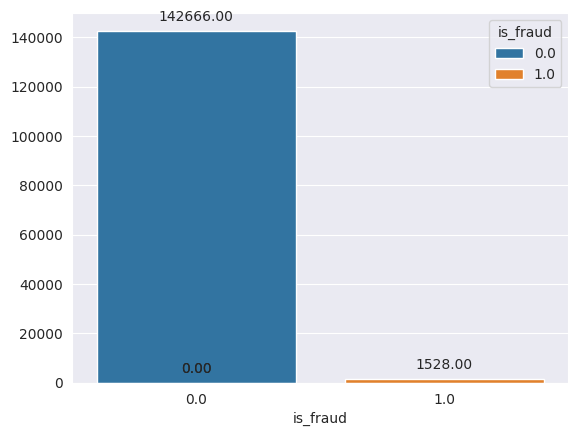

In [ ]:
count_frauds = df_treino_prep.groupby('is_fraud').amt.count()
ax = sns.barplot(x=count_frauds.index, y=count_frauds.values, hue=count_frauds.index)

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center',
                va = 'center',
                xytext = (0, 10),
                textcoords = 'offset points')
plt.show()

## Analises das features

Abaixo está uma comparação entre a quatidade de transações Fraudulentas vs quantidade de transações não frauduletas por estado.

Neste gráfico é possível ter uma percepção inicial de que os dados de fraude estão equilibrados, onde nos estados que apresentam maior quantidade de transações, também são apresentados um número mmaior de fraudes

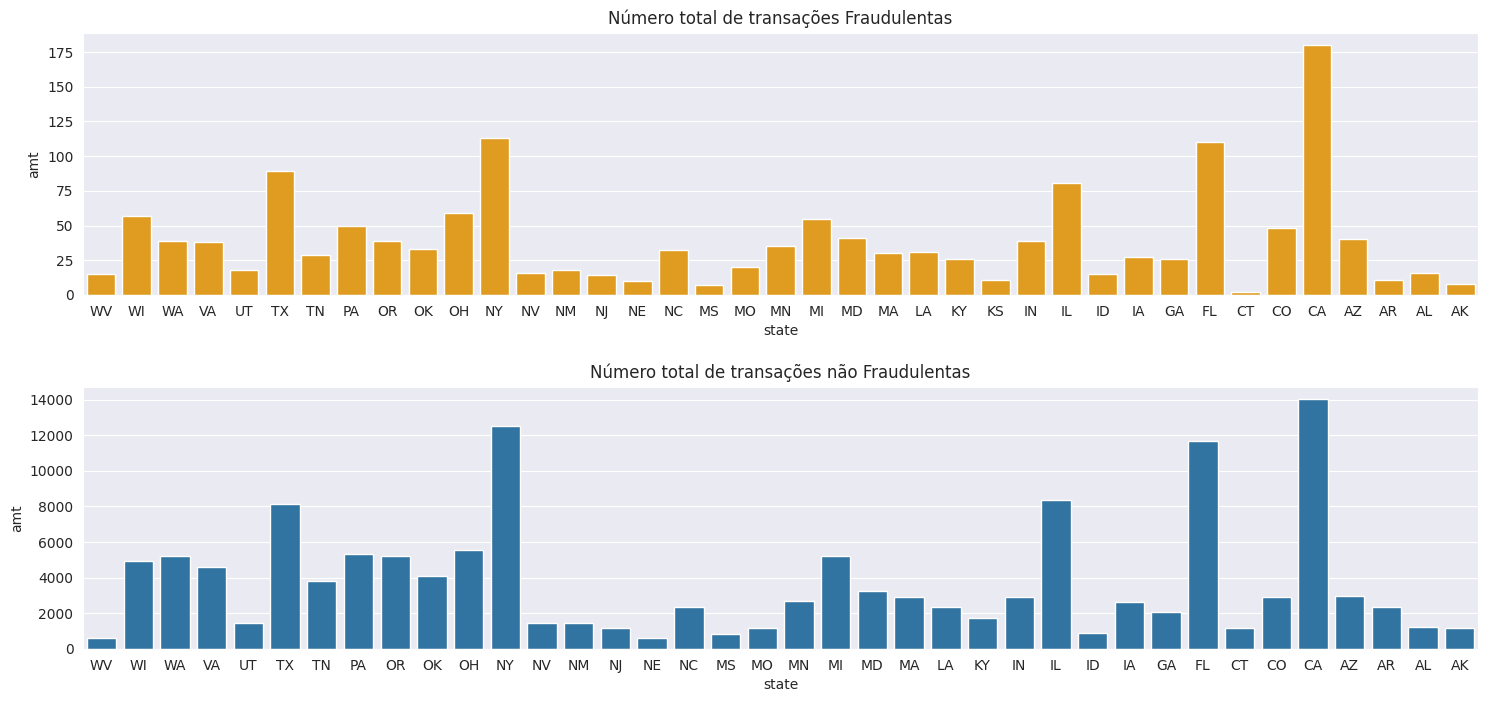

In [ ]:
count_frauds = df_treino_prep.groupby(['state', 'is_fraud']).amt.count().reset_index().sort_values(by='state', ascending=False)
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(18,8))
plt.subplots_adjust(hspace=0.35)
sns.barplot(data=count_frauds.query("is_fraud==1.0"), x='state', y='amt', ax=ax1, color='orange')
ax1.set_title("Número total de transações Fraudulentas")
sns.barplot(data=count_frauds.query("is_fraud==.0"), x='state', y='amt', ax=ax2)
ax2.set_title("Número total de transações não Fraudulentas")
plt.show()

A tabela abaixo mostra os 10 estados com maior percentual de fraudes em cartão de crédito.

Verificando qual estado tem um percetual maior de fraudes, WV  fica em primeiro com 2,56%, MO em segundo com 1,70% e NE em terceiro com 1,68%

is_fraud,state,0.0,1.0,%_fraud
38,WV,585.0,15.0,2.564103
20,MO,1170.0,20.0,1.709402
23,NE,592.0,10.0,1.689189
10,ID,900.0,15.0,1.666667
5,CO,2921.0,48.0,1.643273
14,KY,1743.0,26.0,1.491681
22,NC,2329.0,32.0,1.373980
3,AZ,2941.0,40.0,1.360082
12,IN,2898.0,39.0,1.345756
1,AL,1197.0,16.0,1.336675


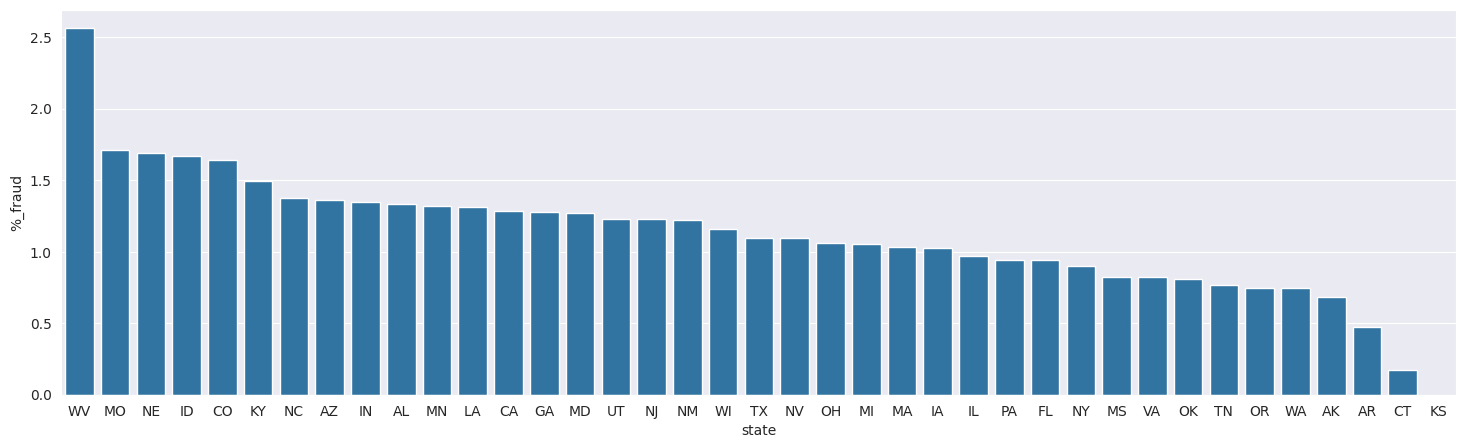

In [ ]:
count_frauds = df_treino_prep.groupby(['state', 'is_fraud']).amt.count().reset_index().sort_values(by='amt', ascending=False)
df_per_state = count_frauds.pivot(index='state', columns='is_fraud', values='amt').reset_index()
df_per_state['%_fraud'] = df_per_state[1.0] / df_per_state[0.0] * 100
df_per_state = df_per_state.sort_values(by='%_fraud', ascending=False)

fig, ax = plt.subplots(figsize=(18,5))
sns.barplot(data=df_per_state, x='state', y='%_fraud', ax=ax)
df_per_state.head(10)

Analisando a quantidade de transações fraudulentas vs não fraudulentas por categoria de compra, podemos observar que, em números absolutos, as duas maiores categorias com maior incidencia de fraudes são respectivamente: shopping_net e gracery_pos

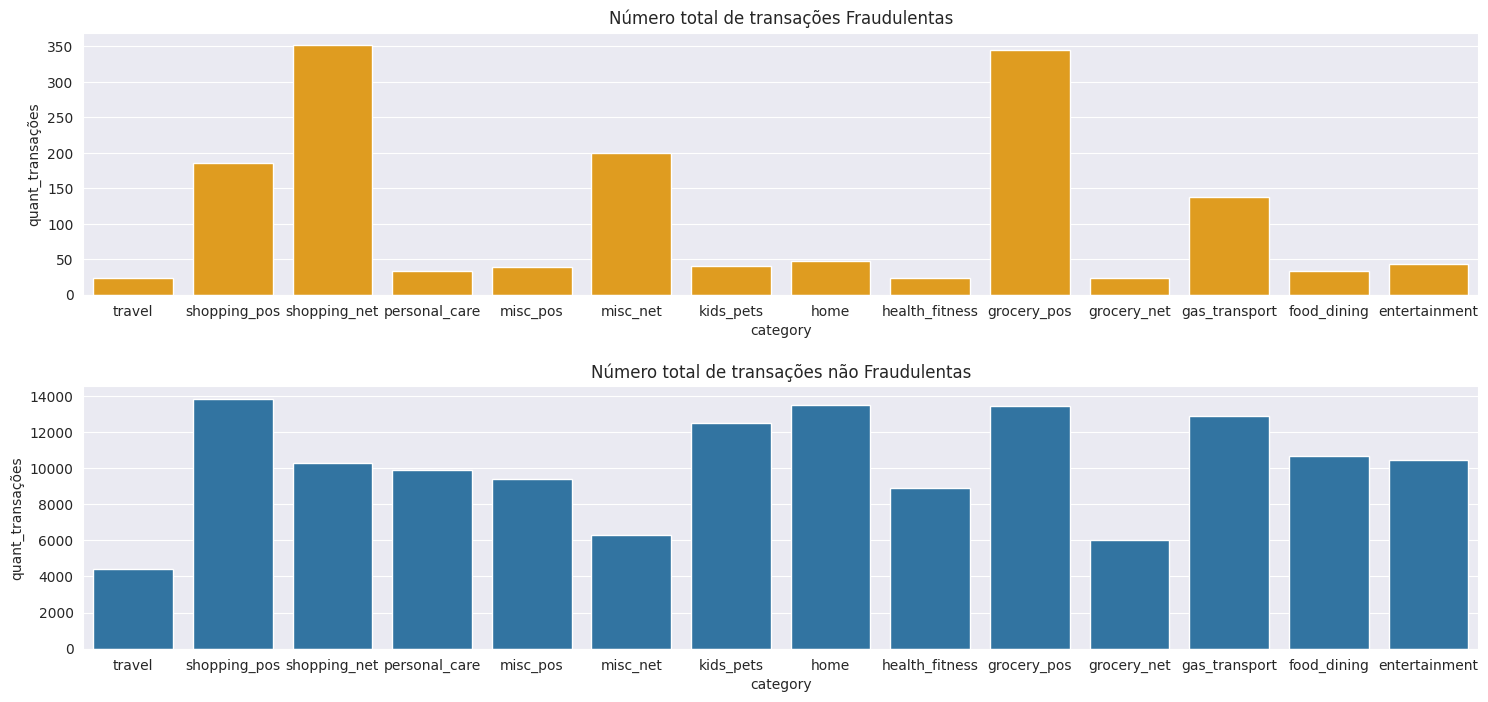

In [ ]:
count_frauds = df_treino_prep.groupby(['category', 'is_fraud']).acct_num.count().reset_index().sort_values(by='category', ascending=False)
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(18,8))
plt.subplots_adjust(hspace=0.35)
sns.barplot(data=count_frauds.query("is_fraud==1.0"), x='category', y='acct_num', ax=ax1, color='orange')
ax1.set_title("Número total de transações Fraudulentas")
sns.barplot(data=count_frauds.query("is_fraud==.0"), x='category', y='acct_num', ax=ax2)
ax2.set_title("Número total de transações não Fraudulentas")
ax1.set_ylabel("quant_transações")
ax2.set_ylabel("quant_transações")
plt.show()

Agora olhando pro percentual de transações fraudulentas, shopping_net se mantêm como a principal com 3,42% das compras como fraudulentas, e misc_net sobe para segundo lugar com 3,16%. Grocery_pos fica em terceiro com 2,56%.

is_fraud,category,0.0,1.0,%_fraud
11,shopping_net,10281,352,3.423791
8,misc_net,6326,200,3.161555
4,grocery_pos,13475,345,2.560297
12,shopping_pos,13846,186,1.343348
2,gas_transport,12885,138,1.071013
13,travel,4437,23,0.518368
9,misc_pos,9433,39,0.413442
0,entertainment,10438,43,0.411956
3,grocery_net,6040,24,0.397351
6,home,13494,47,0.348303


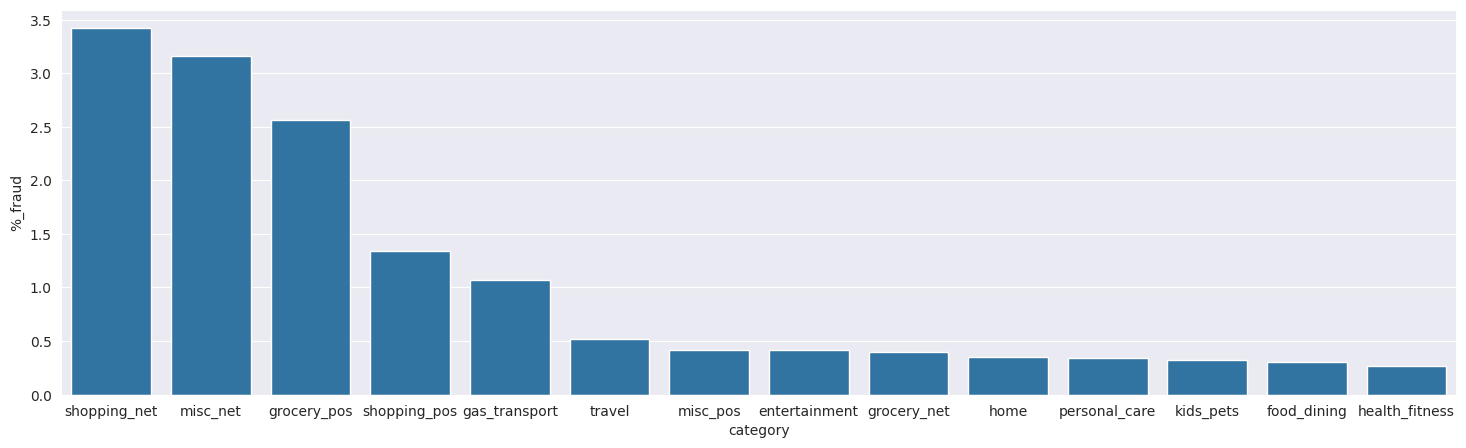

In [ ]:
count_frauds = df_treino_prep.groupby(['category', 'is_fraud']).amt.count().reset_index().sort_values(by='amt', ascending=False)
df_per_category = count_frauds.pivot(index='category', columns='is_fraud', values='amt').reset_index()
df_per_category['%_fraud'] = df_per_category[1.0] / df_per_category[0.0] * 100
df_per_category = df_per_category.sort_values(by='%_fraud', ascending=False)


fig, ax = plt.subplots(figsize=(18,5))
sns.barplot(data=df_per_category, x='category', y='%_fraud', ax=ax)
df_per_category

Olhando para a última variável categorica "profile", vemos que a categoria com maior percentual de fraudes é adults_2550_male_rural, no entanto, a quantidade de transações nessa categoria é a menor de todas.

Considerando categorias que tem acima de 1000 transações, a categoria adults_50up_female_urban é que apresenta o maior percentual de fraudes

In [ ]:
comp_frauds = df_treino_prep.groupby(['profile','is_fraud'])['amt'].count().reset_index()
df_per_profile = comp_frauds.pivot(index='profile', columns='is_fraud', values='amt').reset_index()
df_per_profile['%_fraud'] = df_per_profile[1.0] / df_per_profile[0.0] * 100
df_per_profile = df_per_profile.sort_values(by='%_fraud', ascending=False)
df_per_profile

is_fraud,profile,0.0,1.0,%_fraud
2,adults_2550_male_rural.json,294,9,3.061224
5,adults_50up_female_urban.json,21240,385,1.812618
7,adults_50up_male_urban.json,17666,303,1.715159
0,adults_2550_female_rural.json,2327,34,1.461109
9,young_adults_male_urban.json,5239,68,1.297958
6,adults_50up_male_rural.json,3240,30,0.925926
3,adults_2550_male_urban.json,43376,348,0.802287
4,adults_50up_female_rural.json,1495,11,0.735786
1,adults_2550_female_urban.json,34451,250,0.725668
8,young_adults_female_urban.json,13338,90,0.674764


Abaixo, vemos que a categoria adults_50up_female_urban tem a maior quantidade de transações fraudulentas, mas não é maior em quantidade de transações não fraudulentas, sendo a adults_2550_male_urban ocupando esse posto.

<ipython-input-25-f4e7f51c8f31>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
<ipython-input-25-f4e7f51c8f31>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')


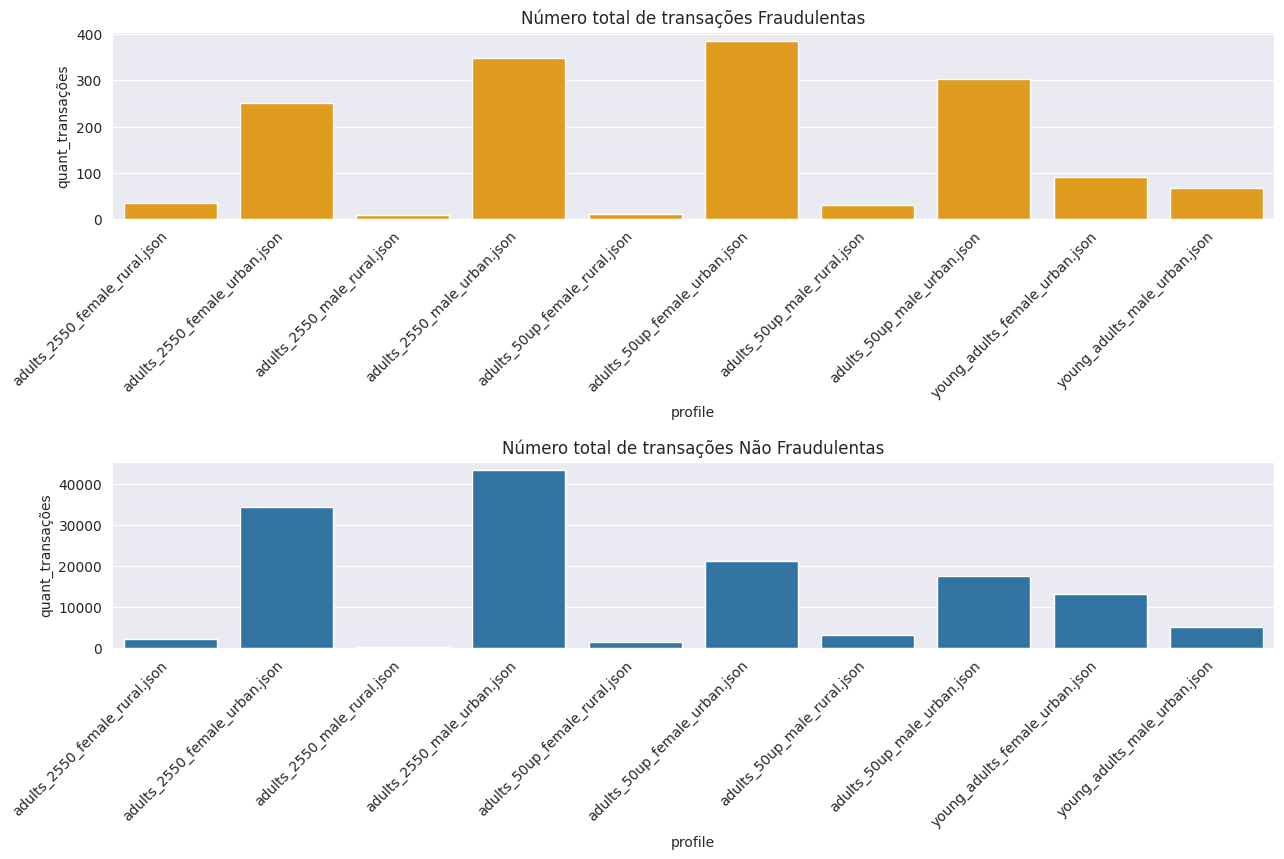

In [ ]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(15,8))
plt.subplots_adjust(hspace=1.3)
sns.barplot(comp_frauds.query('is_fraud==1.0'), x='profile', y='amt', ax=ax1, color='orange')
sns.barplot(comp_frauds.query('is_fraud==0.0'), x='profile', y='amt', ax=ax2)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
ax1.set_title("Número total de transações Fraudulentas")
ax2.set_title("Número total de transações Não Fraudulentas")
ax1.set_ylabel("quant_transações")
ax2.set_ylabel("quant_transações")
plt.show()

Por fim, uma análise da distribuição do valor total das transações que são fraudes, por ano, mes, dia, hora e minuto (variáveis numéricas).

As observações são as seguintes:
- A variavél ano não tem relevância para o modelo, pelo simples de ser algo quee não irá se repetir quando fizer a previsão.
- As variáveis mem e minuto apresentam poucas variáções significativas nos gráficos abaixo, podendo não contribuir muito para previsão do modelo.
- Na variável dia, temos uma grande variação do montante de fraudes nos dias 9 e 10.
- A variável hora é a que apresenta um compotamento parece contribuir mais para a previsão do modelo. Podemos observar que entre 0 e 11 horas as fraudes realizadas tem um montante menor do que as fraudes realizadas entre 12 e 23 h

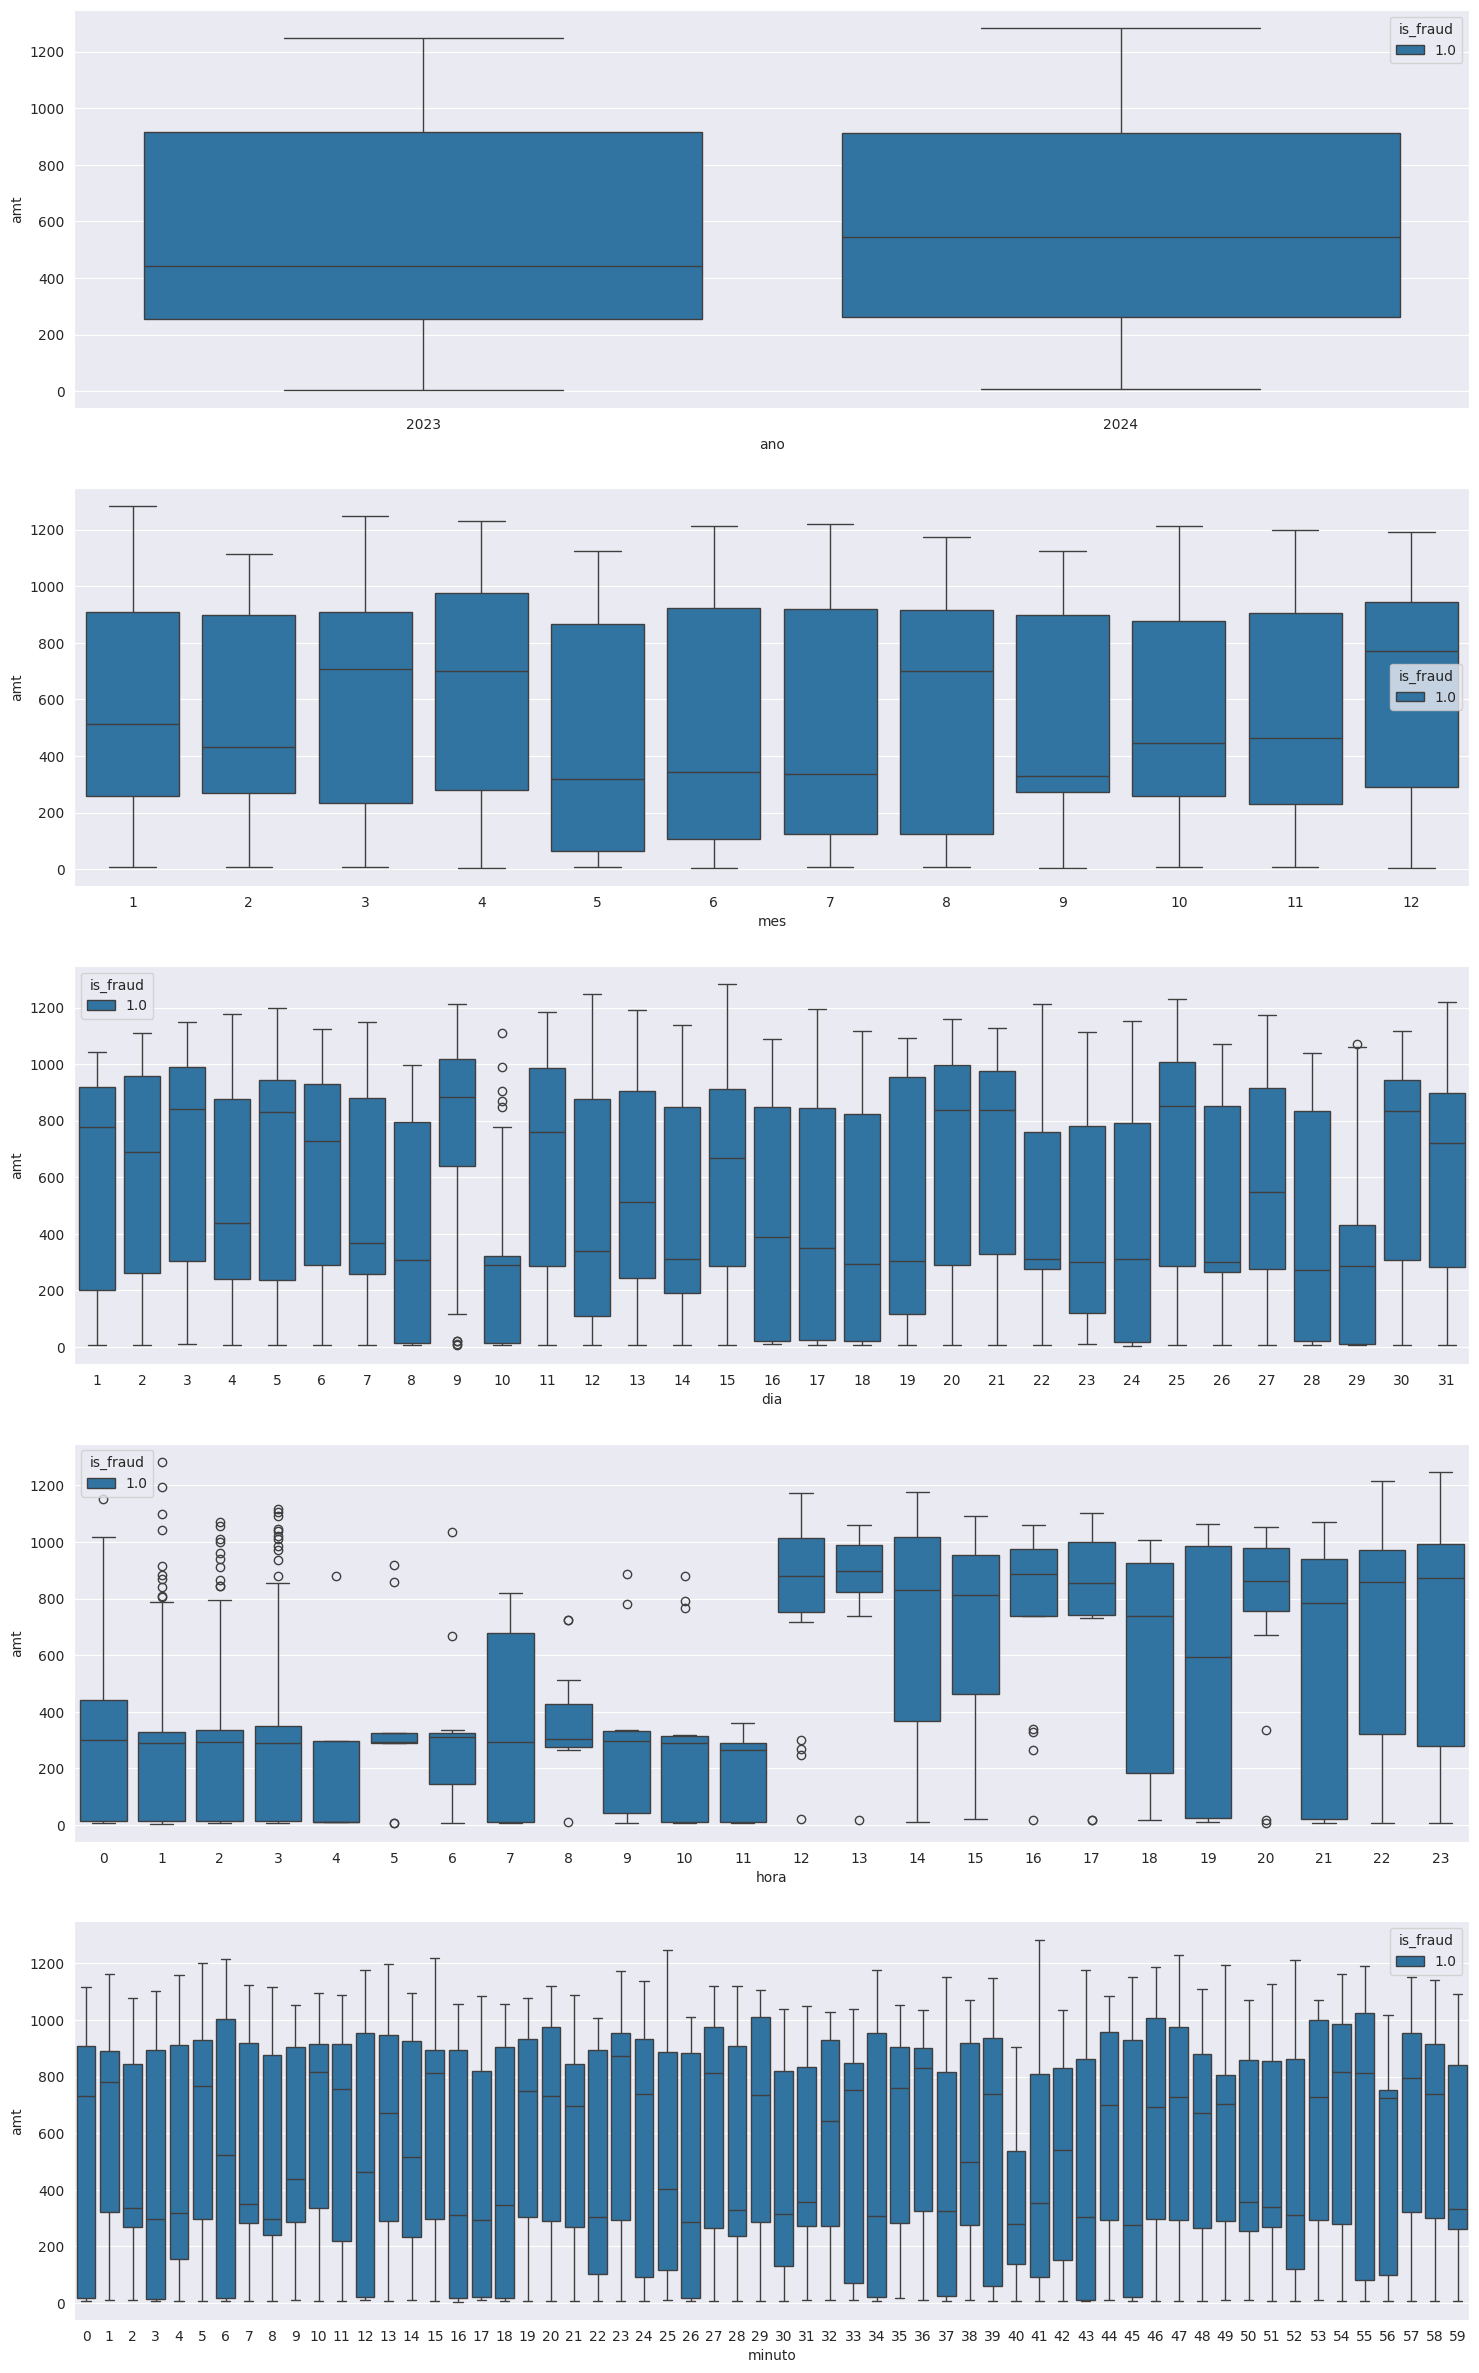

In [ ]:
# max_value_fraud = df_treino_prep.query("is_fraud==1.0")['amt'].max()
max_value_fraud = 999999999

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5,1,figsize=(18,30))
sns.boxplot(data=df_treino_prep.query(f'amt<={max_value_fraud} and is_fraud==1.0'), x='ano', y='amt', hue='is_fraud', ax=ax1)
sns.boxplot(data=df_treino_prep.query(f'amt<={max_value_fraud} and is_fraud==1.0'), x='mes', y='amt', hue='is_fraud', ax=ax2)
sns.boxplot(data=df_treino_prep.query(f'amt<={max_value_fraud} and is_fraud==1.0'), x='dia', y='amt', hue='is_fraud', ax=ax3)
sns.boxplot(data=df_treino_prep.query(f'amt<={max_value_fraud} and is_fraud==1.0'), x='hora', y='amt', hue='is_fraud', ax=ax4)
sns.boxplot(data=df_treino_prep.query(f'amt<={max_value_fraud} and is_fraud==1.0'), x='minuto', y='amt', hue='is_fraud', ax=ax5)
plt.show()

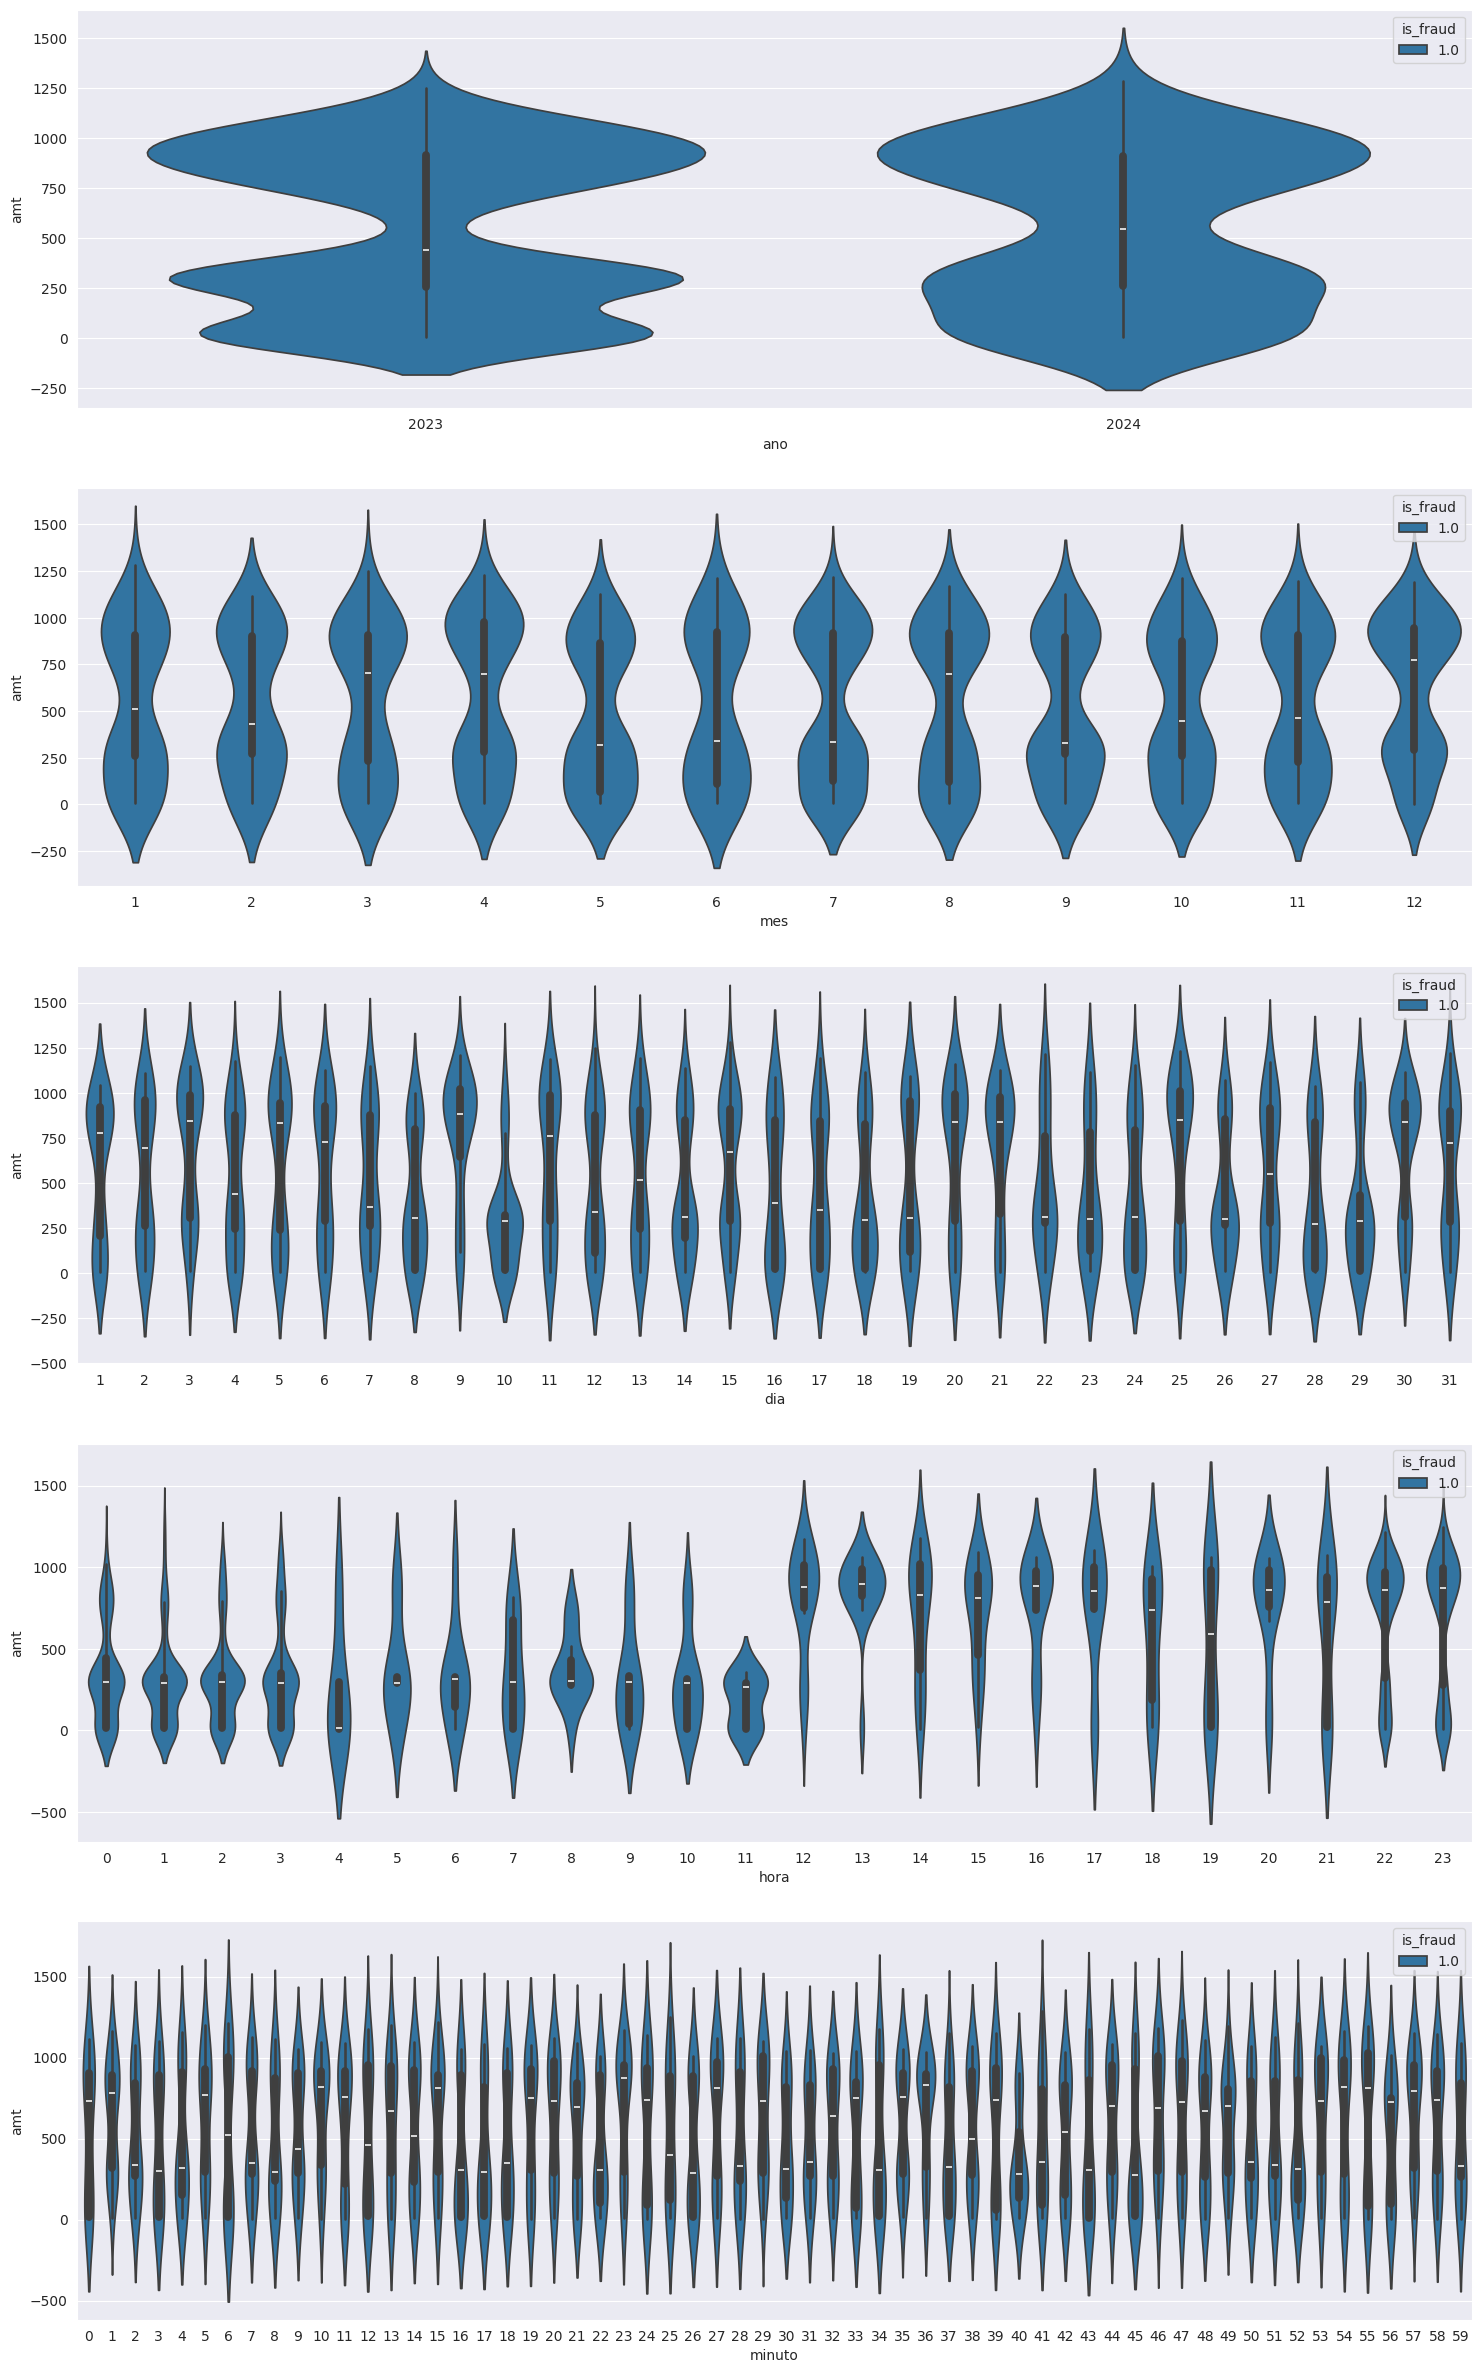

In [ ]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5,1,figsize=(18,30))
sns.violinplot(data=df_treino_prep.query(f'amt<={max_value_fraud} and is_fraud==1.0'), x='ano', y='amt', hue='is_fraud', ax=ax1)
sns.violinplot(data=df_treino_prep.query(f'amt<={max_value_fraud} and is_fraud==1.0'), x='mes', y='amt', hue='is_fraud', ax=ax2)
sns.violinplot(data=df_treino_prep.query(f'amt<={max_value_fraud} and is_fraud==1.0'), x='dia', y='amt', hue='is_fraud', ax=ax3)
sns.violinplot(data=df_treino_prep.query(f'amt<={max_value_fraud} and is_fraud==1.0'), x='hora', y='amt', hue='is_fraud', ax=ax4)
sns.violinplot(data=df_treino_prep.query(f'amt<={max_value_fraud} and is_fraud==1.0'), x='minuto', y='amt', hue='is_fraud', ax=ax5)
plt.show()

# Preparação para ML

## Transformando dados categoricos

In [ ]:
dados_cat = df_treino_prep[['state', 'category', 'profile']]
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
dados_cat_transformados = encoder.fit_transform(dados_cat)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
encoder.categories_

[array(['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'FL', 'GA', 'IA', 'ID',
        'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'MI', 'MN', 'MO', 'MS',
        'NC', 'NE', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'TN',
        'TX', 'UT', 'VA', 'WA', 'WI', 'WV'], dtype=object),
 array(['entertainment', 'food_dining', 'gas_transport', 'grocery_net',
        'grocery_pos', 'health_fitness', 'home', 'kids_pets', 'misc_net',
        'misc_pos', 'personal_care', 'shopping_net', 'shopping_pos',
        'travel'], dtype=object),
 array(['adults_2550_female_rural.json', 'adults_2550_female_urban.json',
        'adults_2550_male_rural.json', 'adults_2550_male_urban.json',
        'adults_50up_female_rural.json', 'adults_50up_female_urban.json',
        'adults_50up_male_rural.json', 'adults_50up_male_urban.json',
        'young_adults_female_urban.json', 'young_adults_male_urban.json'],
       dtype=object)]

In [ ]:
dados_cat_transformados

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## Transformando dados numéricos

In [ ]:
dados_num = df_treino_prep[['amt', 'dia', 'mes', 'hora', 'minuto']]
dados_num

,amt,dia,mes,hora,minuto
0,2.27,23,7,15,23
1,10.52,13,12,22,13
2,149.01,23,7,23,46
3,32.01,29,1,16,45
4,137.31,18,6,4,16
...,...,...,...,...,...
144347,1.94,11,8,0,53
144348,34.83,11,5,11,50
144349,1.01,18,4,0,48
144350,47.42,8,7,11,28


In [ ]:
scaler = StandardScaler()
dados_num_transformados = scaler.fit_transform(dados_num)

In [ ]:
dados_num_transformados

array([[-0.40189794,  0.81097983, -0.05001019,  0.29399532, -0.38010184],
       [-0.3538952 , -0.3138694 ,  1.40667406,  1.32515648, -0.95640696],
       [ 0.45191075,  0.81097983, -0.05001019,  1.47246522,  0.94539996],
       ...,
       [-0.40922927,  0.24855522, -0.92402075, -1.91563574,  1.06066098],
       [-0.13919205, -0.87629401, -0.05001019, -0.29523963, -0.09194927],
       [-0.33597418, -1.43871862, -1.50669445,  0.29399532,  1.52170509]])

## Montando pipeline de pré-processamento

In [ ]:
class SelectTransformNumParamns(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = self.__transfomDate(X)
        return X[['amt', 'dia', 'mes', 'hora', 'minuto']]

    def __transfomDate(self, X):
        X['trans_date'] = pd.to_datetime(X['trans_date'])
        X['trans_time'] = pd.to_datetime(X['trans_time'])
        X['dia'] = X['trans_date'].dt.day
        X['mes'] = X['trans_date'].dt.month
        X['ano'] = X['trans_date'].dt.year
        X['hora'] = X['trans_time'].dt.hour
        X['minuto'] = X['trans_time'].dt.minute
        return X


In [ ]:
num_pipeline = Pipeline([('selectNum', SelectTransformNumParamns()), ('scaller', StandardScaler())])
df_treino_pipe = num_pipeline.fit_transform(df_treino)

<ipython-input-34-021bb3987f8f>:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  X['trans_time'] = pd.to_datetime(X['trans_time'])


In [ ]:
num_atribs = list(df_treino_prep[['amt', 'trans_date', 'trans_time']])
cat_atribs = list(df_treino_prep[['state', 'category', 'profile']])

full_pipeline = ColumnTransformer([('num', num_pipeline, num_atribs), ('cat', OneHotEncoder(sparse=False, handle_unknown='ignore'), cat_atribs)])

In [ ]:
df_treino_prep = df_treino.dropna(subset='is_fraud', axis=0).copy()

X = df_treino_prep.drop('is_fraud', axis=1)
y = df_treino_prep['is_fraud']

X_prepared = full_pipeline.fit_transform(X)
X_prepared

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[-0.40189794,  0.81097983, -0.05001019, ...,  0.        ,
         0.        ,  0.        ],
       [-0.3538952 , -0.3138694 ,  1.40667406, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.45191075,  0.81097983, -0.05001019, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.40922927,  0.24855522, -0.92402075, ...,  0.        ,
         0.        ,  0.        ],
       [-0.13919205, -0.87629401, -0.05001019, ...,  1.        ,
         0.        ,  0.        ],
       [-0.33597418, -1.43871862, -1.50669445, ...,  0.        ,
         0.        ,  0.        ]])

# Treinamento Modelos

## Funções auxiliares

In [ ]:
print(X_prepared.shape)
print(y.shape)

(144194, 68)
(144194,)


In [ ]:
def print_scores(scores):
    scores_models = list(scores.keys())
    keys = scores[scores_models[0]].keys()

    for k in keys:
        print(f"Metric: {k}")
        for m in scores_models:
            scr = scores[m][k]
            print(f"Model {m:15} : Mean {scr.mean():.3f} --> {scores[m][k]}")

        print("")

def run_cross_validate(model, X, y, print_score=False):
    scoring = {
        'roc_auc': 'roc_auc',
        'precision': make_scorer(precision_score, zero_division=1),
        'recall': 'recall',
        'f1': 'f1'
    }

    scores_ = cross_validate(model, X, y, cv=5, return_train_score=True, scoring=scoring)
    if print_score:
        print_scores({str(model.estimator):scores_})
    return scores_

def runMLModels(X, y):

    treeClf = DecisionTreeClassifier()
    scores_treeClf = run_cross_validate(treeClf, X, y)

    logClf = LogisticRegression(solver='newton-cholesky', max_iter=20)
    scores_logClf = run_cross_validate(logClf, X, y)

    random_forest = RandomForestClassifier()
    scores_random_forest = run_cross_validate(random_forest, X, y)

    xgBoost = GradientBoostingClassifier()
    scores_xgboost = run_cross_validate(xgBoost, X, y)

    dummie = DummyClassifier()
    scores_dummie = run_cross_validate(dummie, X, y)

    all_scores = {
        'dummy':scores_dummie,
        'random_forest':scores_random_forest,
        'Decision_tree':scores_treeClf,
        'Logistic_reg':scores_logClf,
        'GradientBoosting':scores_xgboost
    }
    print_scores(all_scores)

    return all_scores


Nas rotinas a seguir, comparo o resultado de cada modelo em cada métrica, em treino e teste sendo elas:

- roc_auc (Métrica utilizada na competição)
- precision
- recall
- f1

Na comparações, uso os seguintes modelos:

- dummy (para comparação de performace dos outros modelos)
- Random Forest
- Decision Tree
- Logistic_regression
- GradientBoosting

## Teste 1 - Utilizando dados desbalanceados

In [ ]:
scores_test_1 = runMLModels(X_prepared, y)

Metric: fit_time
Model dummy           : Mean 0.044 --> [0.04591703 0.04110146 0.04317713 0.04305816 0.04832625]
Model random_forest   : Mean 18.872 --> [19.31685233 20.98801112 17.79252505 18.06733823 18.19319868]
Model Decision_tree   : Mean 1.710 --> [1.78888392 1.56117463 1.4622817  1.55875945 2.17920971]
Model Logistic_reg    : Mean 1.325 --> [1.66751838 1.26158357 1.236058   1.24154186 1.21670747]
Model GradientBoosting : Mean 61.246 --> [62.29163647 61.21820283 59.69688106 61.64847517 61.37376261]

Metric: score_time
Model dummy           : Mean 0.048 --> [0.04830384 0.04822636 0.0482707  0.05025792 0.04718375]
Model random_forest   : Mean 0.949 --> [0.87460637 0.88214564 1.10894823 1.02020836 0.85916805]
Model Decision_tree   : Mean 0.071 --> [0.06339765 0.06278729 0.06868672 0.06166053 0.09656906]
Model Logistic_reg    : Mean 0.086 --> [0.08422732 0.08533192 0.08895397 0.08112383 0.08876014]
Model GradientBoosting : Mean 0.143 --> [0.14240026 0.14244962 0.14546847 0.14291191 0

## Rebalanceando os Dados

#### Teste 02 - Utlizando técnica de Under Sampling

In [ ]:
def calcProporcao(df, col):
    df_proporcao = df.groupby(col)['amt'].count().reset_index()
    total = df_proporcao['amt'].sum()
    df_proporcao['%_original'] = df_proporcao['amt'] / total * 100
    return df_proporcao

cols_cat = ['state', 'category', 'profile']

proporcao_original = {}

for col in cols_cat:
    proporcao_original[col] = calcProporcao(df_treino_prep, col)

In [ ]:
proporcao_original.keys()

dict_keys(['state', 'category', 'profile'])

In [ ]:
nn = NearMiss()
X_res, y_res = nn.fit_resample(X_prepared, y)

In [ ]:
y_res.groupby(y_res.values).count()

0.0    1528
1.0    1528
Name: is_fraud, dtype: int64

In [ ]:
print(X_res.shape)
print(y_res.shape)

(3056, 68)
(3056,)


In [ ]:
scores_test_2 = runMLModels(X_res, y_res)

Metric: fit_time
Model dummy           : Mean 0.001 --> [0.00124526 0.00127339 0.00126529 0.00126219 0.00123334]
Model random_forest   : Mean 0.458 --> [0.38125777 0.38853478 0.51573467 0.50186753 0.50378394]
Model Decision_tree   : Mean 0.013 --> [0.01411819 0.01129937 0.01144695 0.01511574 0.01166201]
Model Logistic_reg    : Mean 0.021 --> [0.02133632 0.02169132 0.02099085 0.02121758 0.02142668]
Model GradientBoosting : Mean 0.589 --> [0.78665614 0.54521179 0.54315066 0.53351116 0.53667045]

Metric: score_time
Model dummy           : Mean 0.007 --> [0.00702477 0.0074625  0.0070107  0.00698876 0.00699186]
Model random_forest   : Mean 0.055 --> [0.03933597 0.05934262 0.05228019 0.07237506 0.05343795]
Model Decision_tree   : Mean 0.010 --> [0.00905538 0.00834537 0.00852084 0.01298356 0.00878501]
Model Logistic_reg    : Mean 0.012 --> [0.01198959 0.01440048 0.01168513 0.01181293 0.01200032]
Model GradientBoosting : Mean 0.011 --> [0.01075506 0.01121807 0.01120663 0.01086283 0.01102495]



#### Teste 03 - Utilizando técnica de Over Sampling

In [ ]:
smote = SMOTE(random_state = 32)
X_smote_res, y_smote_res = smote.fit_resample(X_prepared, y)

In [ ]:
y_smote_res.groupby(y_smote_res.values).count()

0.0    142666
1.0    142666
Name: is_fraud, dtype: int64

In [ ]:
print(X_smote_res.shape)
print(y_smote_res.shape)

(285332, 68)
(285332,)


In [ ]:
scores_test_3 = runMLModels(X_smote_res,y_smote_res)

Metric: fit_time
Model dummy           : Mean 0.078 --> [0.08264732 0.08140302 0.07373428 0.07672024 0.07520795]
Model random_forest   : Mean 58.743 --> [59.18307233 59.15977478 56.27882743 58.79448748 60.2995708 ]
Model Decision_tree   : Mean 7.975 --> [9.13457656 8.42250228 7.49371672 7.63061905 7.19452357]
Model Logistic_reg    : Mean 2.284 --> [1.9912312  3.59669948 1.91799903 1.91170526 2.00231743]
Model GradientBoosting : Mean 153.940 --> [152.35569477 152.03452849 154.59736156 155.79638433 154.91646361]

Metric: score_time
Model dummy           : Mean 0.094 --> [0.09525251 0.09214282 0.09138203 0.09445333 0.09613013]
Model random_forest   : Mean 2.045 --> [1.93875003 1.95970774 2.41372228 1.97792387 1.93344831]
Model Decision_tree   : Mean 0.154 --> [0.21787071 0.13734341 0.11928129 0.17569733 0.11963034]
Model Logistic_reg    : Mean 0.191 --> [0.1785903  0.24163008 0.17459249 0.18183589 0.17638636]
Model GradientBoosting : Mean 0.385 --> [0.3773098  0.37675166 0.39497256 0.3619

## Avaliando melhor teste pelo ROC AUC

In [ ]:
for key in scores_test_1.keys():
    print("Modelo:", key)
    print(" Resultado teste 1: {:.4f}".format(scores_test_1[key]['test_roc_auc'].mean()))
    print(" Resultado teste 2: {:.4f}".format(scores_test_2[key]['test_roc_auc'].mean()))
    print(" Resultado teste 3: {:.4f}".format(scores_test_3[key]['test_roc_auc'].mean()))
    print()

Modelo: dummy
 Resultado teste 1: 0.5000
 Resultado teste 2: 0.5000
 Resultado teste 3: 0.5000

Modelo: random_forest
 Resultado teste 1: 0.9971
 Resultado teste 2: 0.9918
 Resultado teste 3: 1.0000

Modelo: Decision_tree
 Resultado teste 1: 0.8791
 Resultado teste 2: 0.9296
 Resultado teste 3: 0.9974

Modelo: Logistic_reg
 Resultado teste 1: 0.8542
 Resultado teste 2: 0.9311
 Resultado teste 3: 0.9158

Modelo: GradientBoosting
 Resultado teste 1: 0.9914
 Resultado teste 2: 0.9919
 Resultado teste 3: 0.9967



No fim, o modelo Random Forest foi o que apresentou melhor performace no geral, por isso, utilizarei ele para melhor os parâmetros

### Melhorando parâmetros do modelo RandomForest

In [ ]:
model = RandomForestClassifier(random_state=2)

In [ ]:
parametros_busca = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
grid_search = GridSearchCV(estimator=model, param_grid=parametros_busca,
                           scoring='roc_auc', cv=5, n_jobs=-1)
grid_search.fit(X_res, y_res)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=2), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200, 300]},
             scoring='roc_auc')

In [ ]:
best_model = grid_search.best_estimator_

In [ ]:
run_cross_validate(best_model, X_smote_res, y_smote_res, print_score=True)

Metric: fit_time
Model DecisionTreeClassifier() : Mean 159.229 --> [159.3600738  157.43472743 158.0624814  158.97319865 162.3164525 ]

Metric: score_time
Model DecisionTreeClassifier() : Mean 5.059 --> [4.84266114 4.9087162  4.90322757 5.4665556  5.17454624]

Metric: test_roc_auc
Model DecisionTreeClassifier() : Mean 1.000 --> [0.99995129 0.99998283 0.99998295 0.99997721 0.99998125]

Metric: train_roc_auc
Model DecisionTreeClassifier() : Mean 1.000 --> [0.99999696 0.99999578 0.99999555 0.99999566 0.99999581]

Metric: test_precision
Model DecisionTreeClassifier() : Mean 0.997 --> [0.99789148 0.99692394 0.99730722 0.99671432 0.99685436]

Metric: train_precision
Model DecisionTreeClassifier() : Mean 0.998 --> [0.99836367 0.99811002 0.99824973 0.99824965 0.99816244]

Metric: test_recall
Model DecisionTreeClassifier() : Mean 0.999 --> [0.99519854 0.99950936 0.99947429 0.99936915 0.99957943]

Metric: train_recall
Model DecisionTreeClassifier() : Mean 0.999 --> [0.99964953 0.99946553 0.999430

{'fit_time': array([159.3600738 , 157.43472743, 158.0624814 , 158.97319865,
        162.3164525 ]),
 'score_time': array([4.84266114, 4.9087162 , 4.90322757, 5.4665556 , 5.17454624]),
 'test_roc_auc': array([0.99995129, 0.99998283, 0.99998295, 0.99997721, 0.99998125]),
 'train_roc_auc': array([0.99999696, 0.99999578, 0.99999555, 0.99999566, 0.99999581]),
 'test_precision': array([0.99789148, 0.99692394, 0.99730722, 0.99671432, 0.99685436]),
 'train_precision': array([0.99836367, 0.99811002, 0.99824973, 0.99824965, 0.99816244]),
 'test_recall': array([0.99519854, 0.99950936, 0.99947429, 0.99936915, 0.99957943]),
 'train_recall': array([0.99964953, 0.99946553, 0.99943049, 0.99938668, 0.99946554]),
 'test_f1': array([0.99654319, 0.99821497, 0.99838958, 0.99803997, 0.99821504]),
 'train_f1': array([0.99900619, 0.99878732, 0.99883976, 0.99881784, 0.99881356])}

## Selecionar Melhores Features

### Seleção das Melhores Features

In [ ]:
cv = StratifiedKFold(5,shuffle=True,random_state=500)
rfecv = RFECV(
    estimator=best_model,
    step=1,
    cv=cv,
    scoring='roc_auc', #roc_auc
    min_features_to_select=1,
    importance_getter='auto'
)
rfecv.fit(X_res, y_res)
n_features = rfecv.n_features_

In [ ]:
best_model.estimator

DecisionTreeClassifier()

In [ ]:
rfecv.cv_results_

{'mean_test_score': array([0.9494086 , 0.96915232, 0.98548285, 0.98917757, 0.99068767,
        0.99064661, 0.99082695, 0.99142891, 0.99167651, 0.99208414,
        0.99154149, 0.99179809, 0.99216445, 0.9919535 , 0.99260275,
        0.99271938, 0.99249129, 0.99327826, 0.99318506, 0.9934907 ,
        0.99347116, 0.99357454, 0.99355641, 0.99331683, 0.99327598,
        0.99324954, 0.99357931, 0.99369179, 0.9934025 , 0.99376227,
        0.99356127, 0.99352768, 0.99333694, 0.99370516, 0.99342707,
        0.99364975, 0.99365414, 0.99335313, 0.99322782, 0.9932769 ,
        0.99314641, 0.99328878, 0.99291942, 0.99333932, 0.99331868,
        0.99333662, 0.99303834, 0.99353497, 0.99333554, 0.99313102,
        0.99322746, 0.99341312, 0.99315058, 0.99325649, 0.99296828,
        0.99322446, 0.99283263, 0.99332718, 0.99317287, 0.99334313,
        0.99315153, 0.99300619, 0.99290335, 0.99332811, 0.99323638,
        0.99309588, 0.99288521, 0.99313267]),
 'std_test_score': array([0.00920386, 0.01157655, 0

In [ ]:
X_smote_res.shape

(285332, 68)

In [ ]:
n_features

30

In [ ]:
X_treino_selecionado = rfecv.transform(X_smote_res)
run_cross_validate(best_model, X_treino_selecionado, y_smote_res, print_score=True)

Metric: fit_time
Model DecisionTreeClassifier() : Mean 126.920 --> [127.07791209 126.66572595 128.20688295 126.62270832 126.02912021]

Metric: score_time
Model DecisionTreeClassifier() : Mean 4.930 --> [4.6982522  5.26514411 4.73164415 4.70413828 5.2524302 ]

Metric: test_roc_auc
Model DecisionTreeClassifier() : Mean 1.000 --> [0.9999642  0.99999343 0.99999081 0.99998877 0.99999333]

Metric: train_roc_auc
Model DecisionTreeClassifier() : Mean 1.000 --> [0.99999896 0.99999857 0.99999874 0.99999849 0.99999834]

Metric: test_precision
Model DecisionTreeClassifier() : Mean 0.998 --> [0.9987002  0.99821504 0.99814543 0.99786639 0.998041  ]

Metric: train_precision
Model DecisionTreeClassifier() : Mean 0.999 --> [0.99922944 0.99931687 0.99924691 0.99919436 0.99911562]

Metric: test_recall
Model DecisionTreeClassifier() : Mean 0.999 --> [0.9963551  0.9995444  0.99971962 0.99985981 0.99989486]

Metric: train_recall
Model DecisionTreeClassifier() : Mean 1.000 --> [0.99983353 0.99973715 0.999798

{'fit_time': array([127.07791209, 126.66572595, 128.20688295, 126.62270832,
        126.02912021]),
 'score_time': array([4.6982522 , 5.26514411, 4.73164415, 4.70413828, 5.2524302 ]),
 'test_roc_auc': array([0.9999642 , 0.99999343, 0.99999081, 0.99998877, 0.99999333]),
 'train_roc_auc': array([0.99999896, 0.99999857, 0.99999874, 0.99999849, 0.99999834]),
 'test_precision': array([0.9987002 , 0.99821504, 0.99814543, 0.99786639, 0.998041  ]),
 'train_precision': array([0.99922944, 0.99931687, 0.99924691, 0.99919436, 0.99911562]),
 'test_recall': array([0.9963551 , 0.9995444 , 0.99971962, 0.99985981, 0.99989486]),
 'train_recall': array([0.99983353, 0.99973715, 0.99979848, 0.99973715, 0.99973715]),
 'test_f1': array([0.99752627, 0.99887928, 0.9989319 , 0.9988621 , 0.99896707]),
 'train_f1': array([0.99953139, 0.99952696, 0.99952262, 0.99946568, 0.99942629])}

# Submeter Resposta

## Treinando melhor modelo

In [ ]:
use_balanced_data = True

if use_balanced_data:
    best_model.fit(X_treino_selecionado, y_smote_res)
else:
    best_model.fit(X_prepared, y)

## Realizando previsão das probabilidades no dados de teste

### Melhor modelo

In [ ]:
X_teste = full_pipeline.transform(df_teste)
X_teste_selecionado = rfecv.transform(X_teste)
y_pred = best_model.predict_proba(X_teste_selecionado)

<ipython-input-34-021bb3987f8f>:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  X['trans_time'] = pd.to_datetime(X['trans_time'])


In [ ]:
best_model

RandomForestClassifier(max_depth=20, n_estimators=300, random_state=2)

In [ ]:
best_model.classes_

array([0., 1.])

In [ ]:
X_teste.shape

(36047, 68)

In [ ]:
def make_df_submission(y_pred):
    y_prob_is_fraud = pd.DataFrame(y_pred)[1]
    df_submission = df_teste[['trans_num']].copy()
    df_submission['is_fraud'] = y_prob_is_fraud
    return df_submission

In [ ]:
df_submission = make_df_submission(y_pred)

### Realizando Submissão

In [ ]:
df_submission.to_csv('submission_final.csv', index=False)

Para enviar para o kaggle, rodar o código abaixo

In [ ]:
#!kaggle competitions submit -f submission_final.csv -m "submissao vinipmartins" fraude-em-transaes-de-carto-de-crdito

100% 1.86M/1.86M [00:03<00:00, 602kB/s] 
Successfully submitted to Fraude em transações de cartão de crédito